In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [9]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cd_data_24x128_p1

model_dir = 'output/cd_24x128_p1_more_complex_20220803_94d2'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cd_data_24x128_p1()
config_name = "more_complex"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)


Split: time,120; Training: 22135; Validation: 0; Testing: 4427


In [10]:
trainer.setup()

Resuming from 2620...


In [12]:
attentions = trainer.compute_attentions(t=None)

1/26562 - 00:00:00.30
1001/26562 - 00:01:14.10
2001/26562 - 00:02:28.60
3001/26562 - 00:03:34.38
4001/26562 - 00:04:49.88
5001/26562 - 00:06:18.57
6001/26562 - 00:07:43.50
7001/26562 - 00:09:00.45
8001/26562 - 00:10:12.54
9001/26562 - 00:11:15.59
10001/26562 - 00:12:21.25
11001/26562 - 00:13:24.45
12001/26562 - 00:14:27.74
13001/26562 - 00:15:31.27
14001/26562 - 00:16:34.46
15001/26562 - 00:17:36.90
16001/26562 - 00:18:40.61
17001/26562 - 00:19:44.13
18001/26562 - 00:20:58.06
19001/26562 - 00:22:08.74
20001/26562 - 00:23:12.85
21001/26562 - 00:24:25.99
22001/26562 - 00:25:29.46
23001/26562 - 00:26:32.73
24001/26562 - 00:27:35.91
25001/26562 - 00:28:39.46
26001/26562 - 00:29:50.39


In [65]:
from einops.layers.torch import Rearrange
from src.utils import write_pickle

all_indices = np.arange(len(attentions))

time_0 = 0
time_0_indices = all_indices[vit_data.times == time_0]
time_t_indices = all_indices[vit_data.times != time_0]
times_t = vit_data.times[time_t_indices]
orfs_t = vit_data.orfs[time_t_indices]

atts_0 = attentions[time_0_indices]
atts_t = attentions[time_t_indices]

# Duplicate channel 1 images so it matches remaining dataset
repeat = atts_t.shape[0]//atts_0.shape[0]
atts_0 = np.repeat(atts_0, repeat, axis=0)

atts_0 = atts_0.reshape(atts_0.shape[0], 1, atts_0.shape[1], atts_0.shape[2])
atts_t = atts_t.reshape(atts_t.shape[0], 1, atts_t.shape[1], atts_t.shape[2])

all_atts = np.concatenate([atts_0, atts_t], axis=1)

vectorize_att = Rearrange('n b (h) (w) -> n (b h w)')
atts_vectorized = vectorize_att(torch.Tensor(all_atts)).numpy()

print(all_atts.shape, atts_vectorized.shape)

write_pickle((all_atts, atts_vectorized, times_t, orfs_t), f"{trainer.out_dir}/atts_all.pkl")


(22135, 2, 3, 16) (22135, 96)
Wrote output/cd_24x128_p1_more_complex_20220803_94d2/atts_all.pkl


In [72]:
att_indices_120 = np.arange(len(times_t))[times_t == 120]
atts_120 = all_atts[att_indices_120]
atts_vec_120 = atts_vectorized[att_indices_120]

0

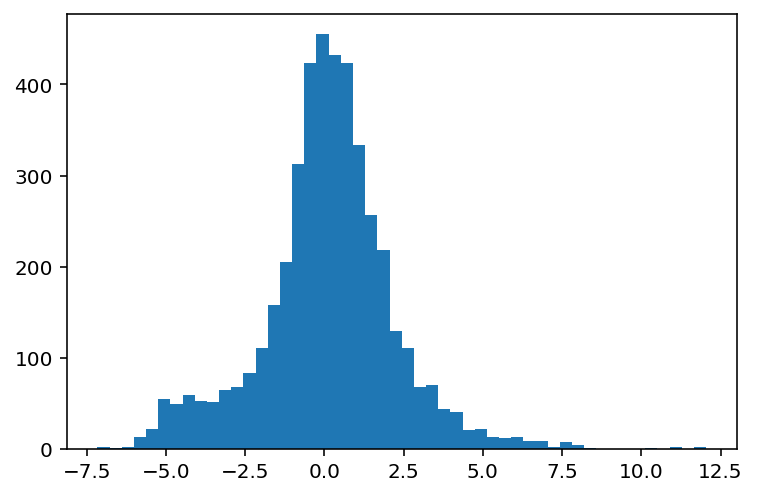

In [103]:
time_120_indices = all_indices[vit_data.times == 120]

tpm_0 = vit_data.unscaled_TPM[time_0_indices]
tpm_120 = vit_data.unscaled_TPM[time_120_indices]

tpm_120_lfc = (np.log2((tpm_120+1) / (tpm_0+1)))
plt.hist(tpm_120_lfc, bins=50)
0

In [73]:
import umap

mapper = umap.UMAP().fit(atts_vec_120)

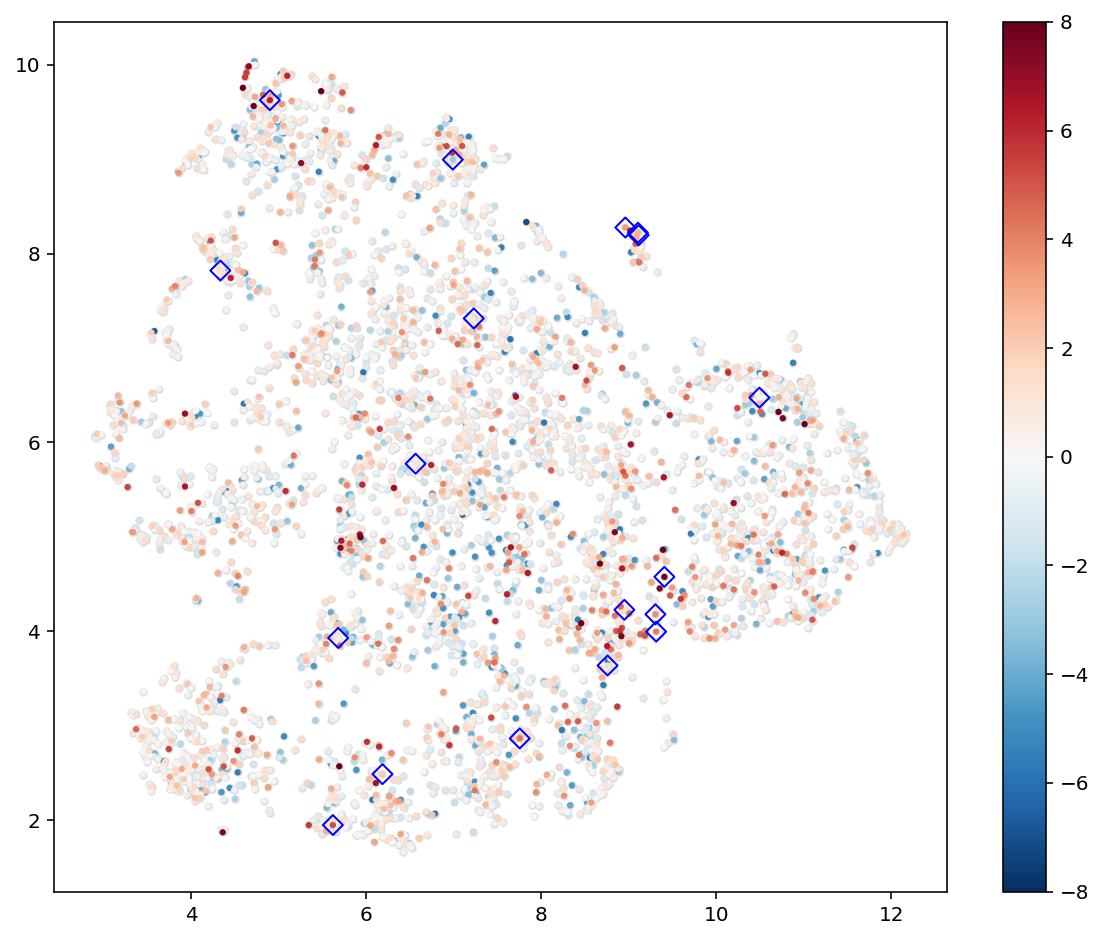

In [140]:
plt.figure(figsize=(10, 8))

plt_data = pd.DataFrame(index=orfs_t[att_indices_120], 
                        data={'index':np.arange(len(tpm_120_lfc)), 'x': mapper.embedding_[:, 0], 
                              'y': mapper.embedding_[:, 1], 'lfc_tpm': tpm_120_lfc})
plt_data = plt_data.sort_values('lfc_tpm')

plt.scatter(plt_data.x, plt_data.y,
            s=10, c='#dddddd')
plt.scatter(plt_data.x, plt_data.y, c=plt_data.lfc_tpm, edgecolor='none',
            s=10, cmap='RdBu_r', vmin=-8, vmax=8)
plt.colorbar()

sulfur_orfs = ['YJL101C', 'YOL049W', 'YNL103W', 'YJR060W',
     'YIR017C', 'YPL038W', 'YDR253C', 'YER091C',
     'YLR180W', 'YDR502C', 'YER043C', 'YDR054C',
     'YDL132W', 'YDR328C', 'YIL046W', 'YGR087C',
     'YAL012W', 'YGR155W']
selected_data = plt_data.loc[sulfur_orfs]

plt.scatter(selected_data.x, selected_data.y, edgecolor='blue', marker='D', facecolor='none',
            s=50)



In [125]:
plt_data.join(vit_data.orfs_data[['name']])

,index,x,y,lfc_tpm,name
YBR092C,202,7.829001,8.335089,-7.162649,PHO3
YBL039C,110,3.577709,7.179758,-6.782980,URA7
YGL147C,1405,7.101197,5.236473,-6.530666,RPL9A
YNL141W,3505,3.999340,6.197062,-6.384071,AAH1
YMR116C,3193,5.211299,8.969477,-6.122913,ASC1
...,...,...,...,...,...
YLL057C,2617,11.008991,6.194590,10.179014,JLP1
YBR294W,353,5.691493,2.569404,11.081871,SUL1
YPL223C,4112,4.590620,9.757331,11.203369,GRE1
YBR072W,187,10.710896,6.324057,11.711861,HSP26


In [166]:
sel_imgs = vit_data.all_imgs[vit_data.orfs == 'YGR087C']

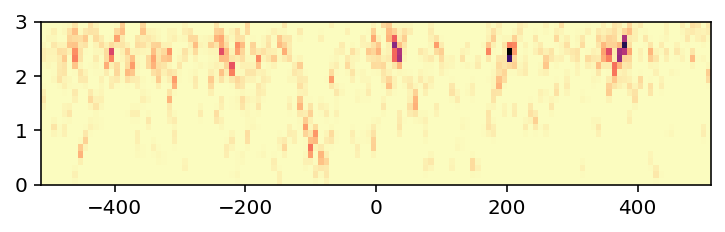

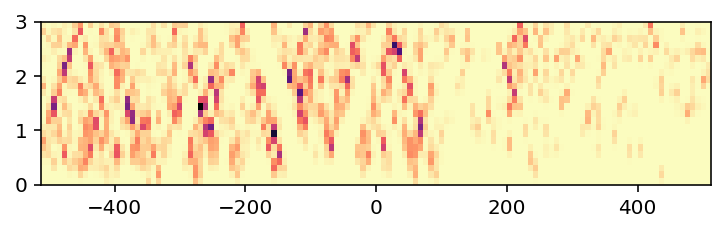

0

In [171]:
plt.figure(figsize=(6, 1.5))
plt.imshow(sel_imgs[0, 0], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 3], aspect='auto')
plt.show()

plt.figure(figsize=(6, 1.5))
plt.imshow(sel_imgs[-1, 0], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 3], aspect='auto')
plt.show()
0

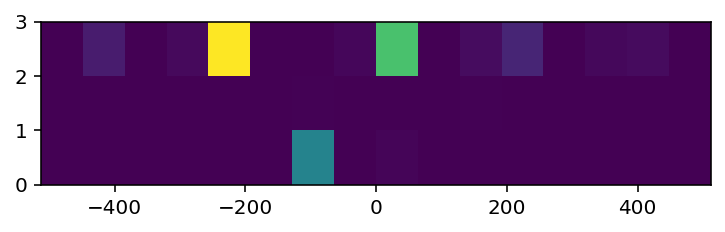

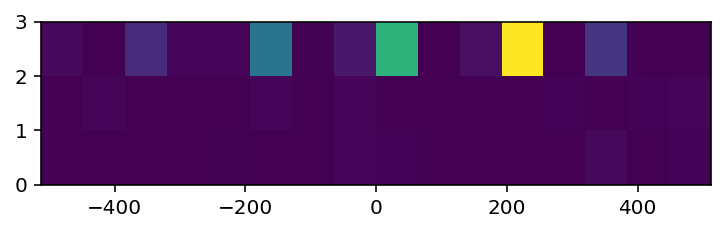

0

In [169]:
all_atts.shape
index = 1571

plt.figure(figsize=(6, 1.5))
plt.imshow(all_atts[187, 0], origin='lower', extent=[-512, 512, 0, 3], aspect='auto')
plt.show()

plt.figure(figsize=(6, 1.5))
plt.imshow(all_atts[187, 1], origin='lower', extent=[-512, 512, 0, 3], aspect='auto')
plt.show()
0